# Notes on Chapter 2 of *Hands-On Machine Learning with Scikit-Learn, Keras, & TensorFlow* by Aurélien Géron

## Download the housing data

In [1]:
import tarfile
import urllib
from pathlib import Path
import shutil
from tempfile import TemporaryFile

housing_dataset_path = Path('datasets') / 'housing' / 'housing.csv'

def fetch_housing_data(
    source_url = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz',
    dest_path = housing_dataset_path
    ):
    # create the destination directory, if needed
    dest_path.parent.mkdir(parents=True, exist_ok=True)
    
    # download the compressed data into a temporary file
    with TemporaryFile() as tempfile:
        with urllib.request.urlopen(source_url) as download:
            shutil.copyfileobj(download, tempfile)

        # extract the compressed data
        tempfile.seek(0)
        with tarfile.open(fileobj=tempfile) as tarobj:
            tarobj.extract(dest_path.name, path=dest_path.parent)

In [2]:
if not housing_dataset_path.exists():
    fetch_housing_data()

## Exploratory data analysis

In [3]:
import pandas as pd

housing = pd.read_csv(housing_dataset_path)

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [8]:
from matplotlib import pyplot as plt

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f47207025f8>,
      dtype=object)

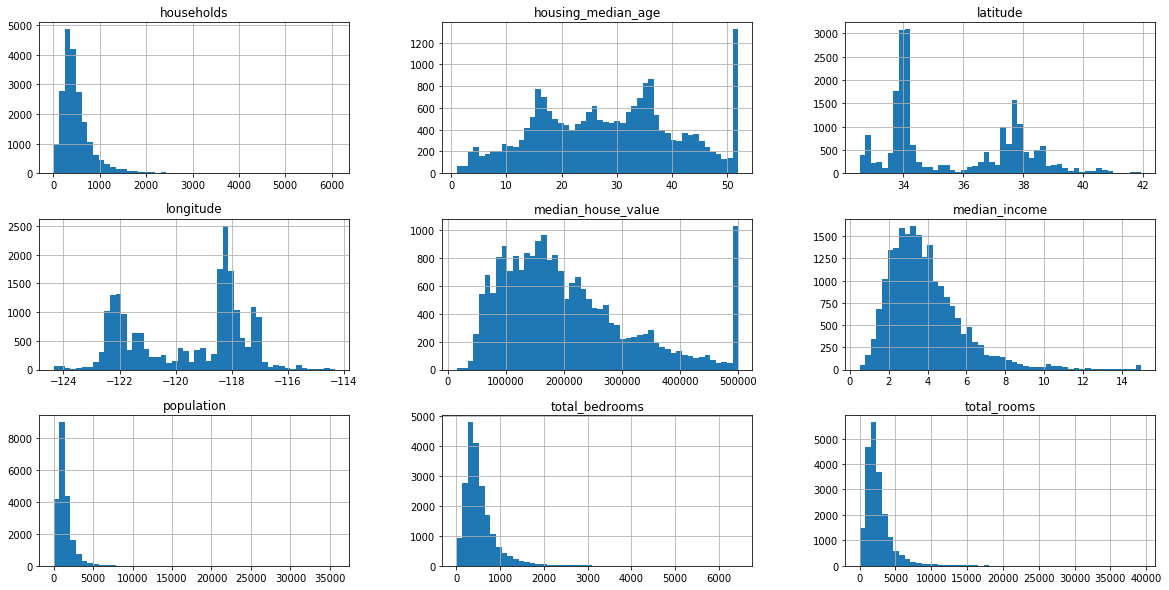

In [9]:
housing.hist(bins=50, figsize=(20,10))

## Set aside the test data

### local implementation...

In [10]:
import numpy as np

def split_test_train(data, test_ratio=0.2):
    N = len(data) # total dataset size
    shuffled_indices = np.random.permutation(N)
    M = int(N * test_ratio) # test dataset size
    return data.iloc[shuffled_indices[M:]], data.iloc[shuffled_indices[:M]]

np.random.seed(42)
train_set, test_set = split_test_train(housing)

In [11]:
(train_set.shape, test_set.shape)

((16512, 10), (4128, 10))

### using scikit learn...

In [12]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [13]:
(train_set.shape, test_set.shape)

((16512, 10), (4128, 10))

### stratified sampling by income...

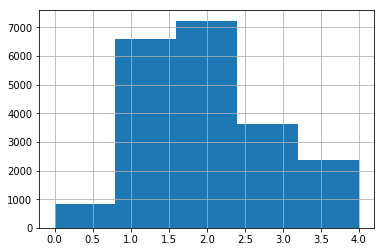

In [14]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0, 1.5, 3.0, 4.5, 6, np.inf], labels=range(5))
housing['income_cat'].hist(bins=5)

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

In [16]:
train_index, test_index = next(StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42).split(housing, housing['income_cat'].astype(int)))
strat_train_set = housing.loc[train_index]
strat_test_set = housing.loc[test_index]

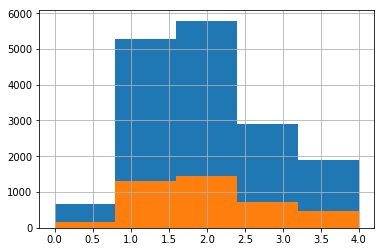

In [17]:
strat_train_set['income_cat'].hist(bins=5)
strat_test_set['income_cat'].hist(bins=5)

Drop the extra column used for stratifying the data

In [18]:
strat_train_set.drop('income_cat', axis=1, inplace=True)
strat_test_set.drop('income_cat', axis=1, inplace=True)

In [19]:
d = strat_train_set

### Geographic visualization

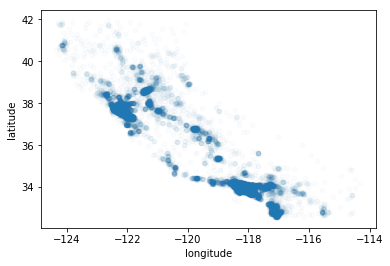

In [20]:
d.plot(kind='scatter', x='longitude', y='latitude', alpha=0.02)

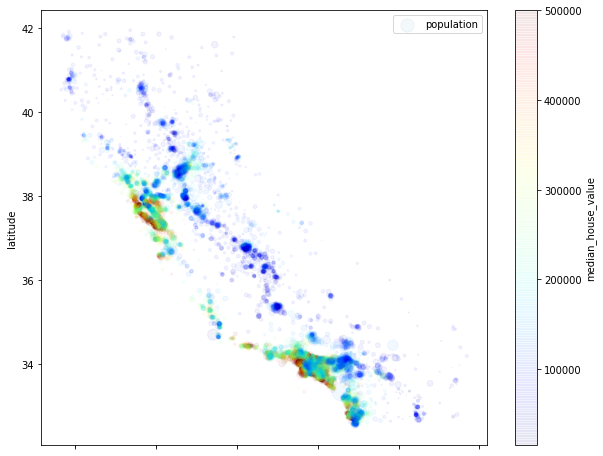

In [21]:
d.plot(kind='scatter', x='longitude', y='latitude', alpha=0.05, s=d['population']/100, label='population', c='median_house_value', cmap='jet', figsize=(10,8))

In [22]:
d.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [23]:
d.corr().median_house_value.sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

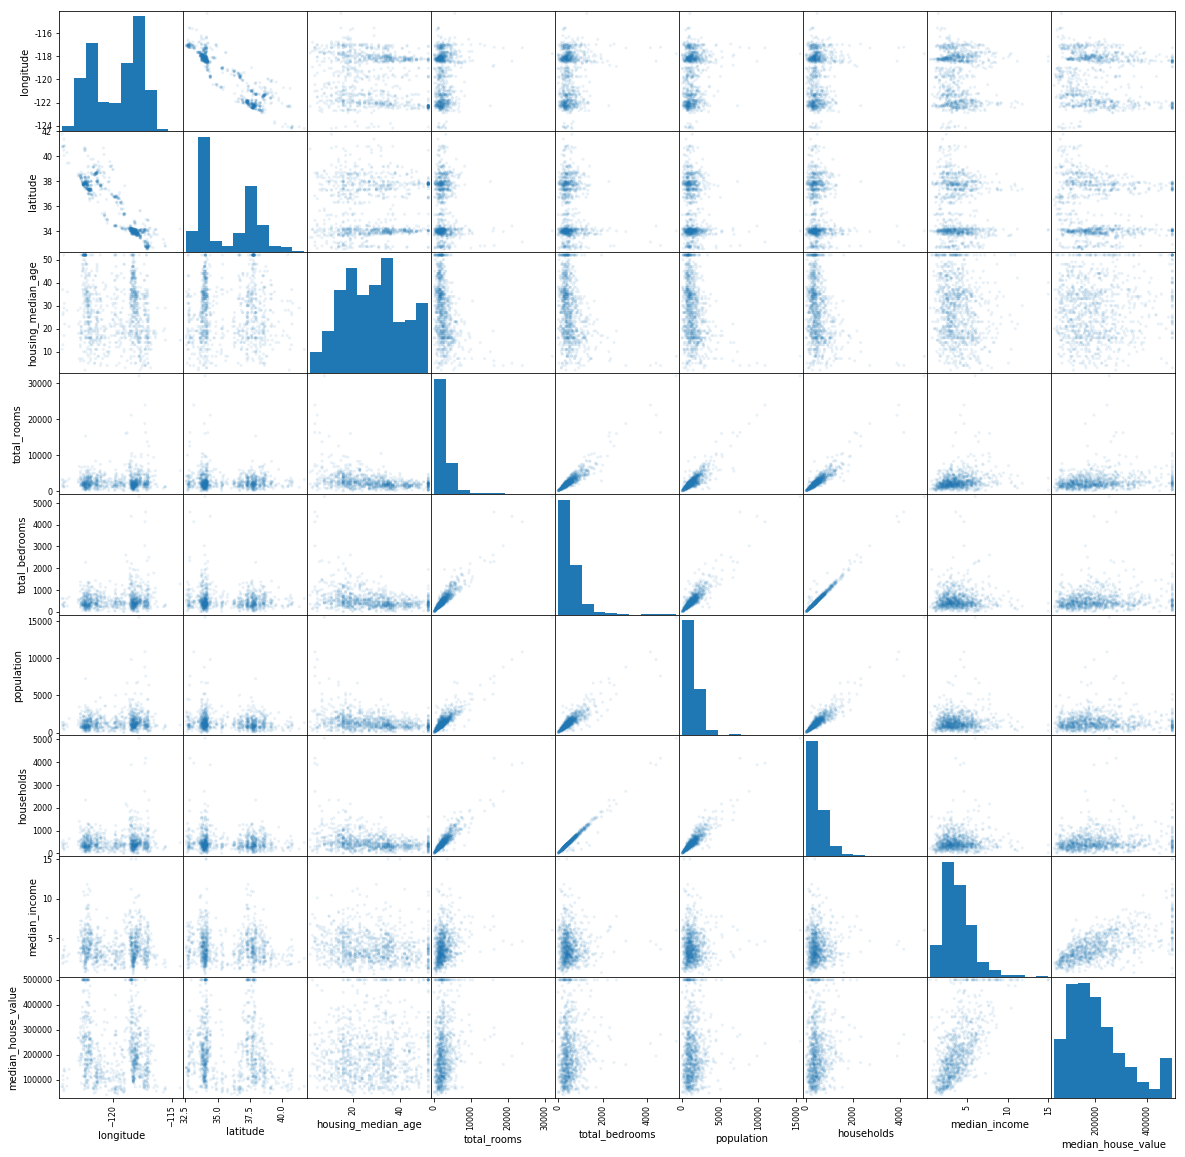

In [24]:
pd.plotting.scatter_matrix(d.head(1000), figsize=(20,20), alpha=0.1)
pass

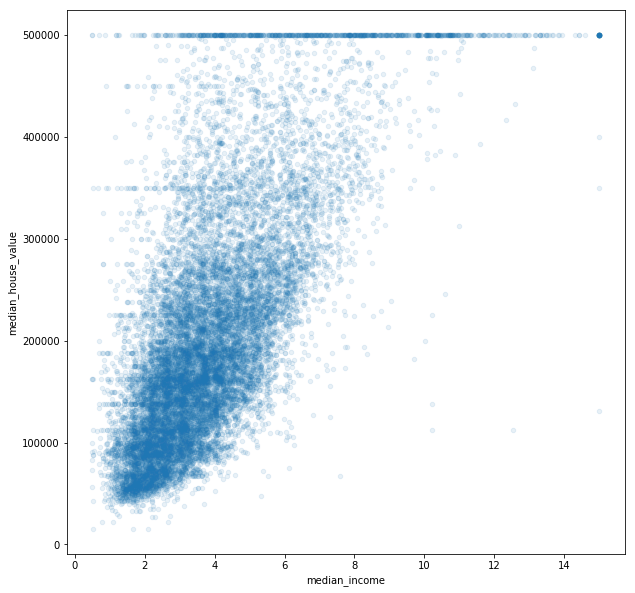

In [25]:
d.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, figsize=(10,10))

Add a few derived attributes...

In [26]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [27]:
housing.corr()['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

Start over again with fresh data, separating the features from the labels.

In [28]:
housing_features = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

Make a version of housing for numeric features.

In [29]:
housing_num = housing.drop('ocean_proximity', axis=1)

#### Train an imputer for missing data (e.g. in total_bedrooms).

In [30]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [34]:
imputer.statistics_ / housing_num.median()

longitude                   1.0
latitude                    1.0
housing_median_age          1.0
total_rooms                 1.0
total_bedrooms              1.0
population                  1.0
households                  1.0
median_income               1.0
median_house_value          1.0
income_cat                  1.0
rooms_per_household         1.0
bedrooms_per_room           1.0
population_per_household    1.0
dtype: float64

In [33]:
housing_num.median()

longitude                     -118.490000
latitude                        34.260000
housing_median_age              29.000000
total_rooms                   2127.000000
total_bedrooms                 435.000000
population                    1166.000000
households                     409.000000
median_income                    3.534800
median_house_value          179700.000000
income_cat                       2.000000
rooms_per_household              5.229129
bedrooms_per_room                0.203162
population_per_household         2.818116
dtype: float64

In [43]:
def transform_df(transform, df):
    return pd.DataFrame(transform.transform(df), columns=df.columns, index=df.index)

In [44]:
housing_tr = transform_df(imputer, housing_num)

In [46]:
housing_num['total_bedrooms'].describe()

count    20433.000000
mean       537.870553
std        421.385070
min          1.000000
25%        296.000000
50%        435.000000
75%        647.000000
max       6445.000000
Name: total_bedrooms, dtype: float64

In [47]:
housing_tr['total_bedrooms'].describe()

count    20640.000000
mean       536.838857
std        419.391878
min          1.000000
25%        297.000000
50%        435.000000
75%        643.250000
max       6445.000000
Name: total_bedrooms, dtype: float64

In [48]:
housing_num['total_bedrooms'].isna().sum(), housing_tr['total_bedrooms'].isna().sum()

(207, 0)

#### Handle categorical data

In [50]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [51]:
housing_cat = housing[['ocean_proximity']]

In [54]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(housing_cat)
housing_cat_encoded = transform_df(ordinal_encoder, housing_cat)

In [55]:
housing_cat_encoded.head()

,ocean_proximity
0,3.0
1,3.0
2,3.0
3,3.0
4,3.0


In [57]:
housing_cat_encoded['ocean_proximity'].value_counts()

0.0    9136
1.0    6551
4.0    2658
3.0    2290
2.0       5
Name: ocean_proximity, dtype: int64

In [67]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(housing_cat)
housing_cat_one_hot = one_hot_encoder.transform(housing_cat)

In [68]:
housing_cat_one_hot.toarray()

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [69]:
one_hot_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Transform for adding derived parameters

In [88]:
from sklearn.base import BaseEstimator, TransformerMixin

class AddDerivedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        if hasattr(X, 'columns'):
            columns=X.columns
        elif X.shape[1] == housing.shape[1]:
            columns=housing.columns
        elif X.shape[1] == housing_num.shape[1]:
            columns=housing_num.columns
        else:
            raise ValueError('no column labels provided and shape does not match housing or housing_num')
        self.i_total_rooms_ = columns.get_loc('total_rooms')
        self.i_total_bedrooms_ = columns.get_loc('total_bedrooms')
        self.i_population_ = columns.get_loc('population')
        self.i_households_ = columns.get_loc('households')
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, self.i_total_rooms_] / X[:, self.i_households_]
        population_per_household = X[:, self.i_population_] / X[:, self.i_households_]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, self.i_total_bedrooms_] / X[:, self.i_total_rooms_]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

feature_adder = AddDerivedFeatures(False)
housing_derived_features = feature_adder.fit_transform(housing.values)

In [91]:
housing_derived_features[0]

array([-122.23, 37.88, 41.0, 880.0, 129.0, 322.0, 126.0, 8.3252, 452600.0,
       'NEAR BAY', 4, 6.984126984126984, 0.14659090909090908,
       2.5555555555555554, 6.984126984126984, 2.5555555555555554],
      dtype=object)

## Exercises